In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [13]:
from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')

import matplotlib.pyplot as plt
import pandas as pd
#plt.rcParams['figure.figsize'] = [15, 15]
#size=18
#params = {'legend.fontsize': size,
#          'figure.figsize': (20,8),
#          'axes.labelsize': size,
#          'axes.titlesize': size,
#          'xtick.labelsize': size*0.75,
#          'ytick.labelsize': size*0.75,
#          'axes.titlepad': 25}
#plt.rcParams.update(params)

mpl.rcParams['figure.figsize'] = [12., 12.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = '14'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [124]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        self.name='GrowthModel'
        self.parameters = ModelParameterArray()      
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=1,val_min=0.,val_max=10.,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [125]:
class ExpModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(ExpModel,self).__init__(  **keywords)
        self.name='Exponential'
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=1000.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (self.N)*np.exp(((nu-self.t_0)/self.tau))
    

In [126]:
class LogisticModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticModel,self).__init__(  **keywords)
        self.name='LogisticModel'
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return self.N/(1+np.exp(-(nu-self.t_0)/self.tau))
    

In [127]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time

In [8]:
def get_data_jh(name='Confirmed',country='Italy',fake_error=False):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19-JH/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']==country]
    df=ts.to_pandas()
    
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>0
    
    #to get each time integer from 1 to N (rather than 0 N-1)
    #dates start from 1 not 0
    time=np.arange(1,len(t)+1)
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001
        
    data_table=Table([time[msk], y[msk], y_err, np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y').date)
    return data,df

def get_data_protezione_civile(name='deceduti',fake_error=False,regione=None):
    
    if regione is None:
        table=Table.read('COVID-19-PROTEZIONECIVILE/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
        df=table.to_pandas()
    else:
        table=Table.read('COVID-19-PROTEZIONECIVILE/dati-regioni/dpc-covid19-ita-regioni.csv')
        df=table.to_pandas()
        df=df[df['denominazione_regione']==regione]
    t=df['data']
    t=pd.to_datetime(t)
    time=np.arange(1,len(t)+1)
    y=df[name]
    msk=y>0
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001

    data_table=Table([time[msk] , y[msk] , y_err[msk], np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,np.array(t.dt.date))

    return data,df


In [94]:
def plot_model(mcmc,model,data,t_start_model=None, t_stop_model=None, size=10,mcmc_samples=500, labels=None,label='',title=''):
    
    fig = plt.figure(constrained_layout=True,figsize=(8,10))

    widths = [1]
    heights = [1, .2, 1]
    spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=widths, height_ratios=heights,hspace=0.4)
    
    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1],sharex=ax1)
    ax3 = fig.add_subplot(spec[2],sharex=ax2)

    if t_start_model is None:
        t_start_model = model.nu_min_fit
    
    if t_stop_model is None:
        t_stop_model = model.nu_max_fit
        
    nu=np.arange(t_start_model,t_stop_model,1)
    
    if hasattr(model,'GrowthModel'):
        p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    
    if mcmc is not None:
        mcmc.reset_to_best_fit()
        y = np.zeros((size,nu.size))

        for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
            for ID_par,pi in  enumerate(mcmc.par_array):
                pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])

            y[ID] = model.eval(nu,get_model=True)

        #print(ID)
        y_min=np.amin(y, axis=0)
        y_max=np.amax(y, axis=0)
        ax1.fill_between(nu,y_max,y_min,color='gray',alpha=0.3)

        mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    if hasattr(model,'GrowthModel'):
        txt=': Predicted\nlog10(R0)/tau=%3.3f'%p
    else:
        txt=': Predicted'
    ax1.plot(nu,y_bf,label= label+txt)
    
    ax1.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    ax1.axvline(model.nu_min_fit,alpha=0.5)
    ax1.axvline(model.nu_max_fit,alpha=0.5)
    
    
    #set x ticks and lables
    locs, labels = plt.xticks()
    
    #add 100 days to final date in data
    delta_t=pd.date_range(data.time[-1], periods=100, freq='d')[1:]
    t=np.append(data.time,delta_t.date)
    delta_x=data.data['nu_data'][-1]+np.arange(1,len(t)-len(data.data['nu_data'])+1)
   
    #sfit letf by 1 to align time with x thicks 
    x=np.append(data.data['nu_data'],delta_x)
    
    ax1.set_xticks(x[::2])
    ax1.set_xticklabels(t[::2],rotation=90)

    
    ax1.set_ylabel('Counts')
    ax1.semilogy()
     
    ax1.legend(loc='best')
     
    ax1.set_xlim(t_start_model-1,t_stop_model)
    ax1.get_xaxis().set_visible(False)
    
    
    
    x_res,y_res=model.get_residuals(log_log=False,data=data.data)
    msk1 = x_res<model.nu_max_fit
    msk2 =x_res>model.nu_min_fit
    x_res=x_res[msk1*msk2]
    y_res=y_res[msk1*msk2]
    line = ax2.errorbar(x_res, y_res, yerr=np.ones(x_res.size), fmt='+')
    ax2.axhline(0,ls='--',alpha=0.5)
    
    ax2.set_xticks(x[::2])
    ax2.set_xticklabels(t[::2],rotation=90)
    ax2.set_xlim(t_start_model-1,t_stop_model)
    #ax2.set_xticklabels(t,rotation=45)
    #plt.setp(ax2.get_xticklabels(), ha="right", rotation=90)
    
    #Model
    ax3.plot(nu  ,np.gradient(y_bf,nu,edge_order=2 ),label='model')
   
    if mcmc is not None:
        y_der = np.zeros((size,nu.size))
        for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
            y_der[ID] = np.gradient(y[ID],nu,edge_order=2) 
        
        y_min=np.amin(y_der, axis=0)
        y_max=np.amax(y_der, axis=0)    
        ax3.fill_between(nu ,y_max  ,y_min  ,color='gray',alpha=0.3)
    
    ax3.plot(data.data['nu_data']  ,np.gradient(data.data['nuFnu_data'],data.data['nu_data']),'o',label='data')
    
    ax3.axvline(model.nu_min_fit,alpha=0.5)
    ax3.axvline(model.nu_max_fit,alpha=0.5)    
    ax3.semilogy()
    ax3.set_xticks(x[::2])
    ax3.set_xticklabels(t[::2],rotation=90)
    ax3.set_xlabel('date')
    ax3.set_ylabel('derivative')
    ax3.set_xlim(t_start_model-1,t_stop_model)
    ax3.legend(loc='best')
    plt.tight_layout()
    fig.suptitle(title,y=1.02)
    
    
    #plt.subplots_adjust(hspace=.0)
    return fig

In [95]:
from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler


In [161]:
def do_analysis(model,data,t_start,t_stop,t_start_model,t_stop_model,name,do_plot=True,do_mcmc=True,mcmc_steps=500,title=''):


    model.nu_min=0
    model.nu_max=100
    #Fix error on the last entry of the latest update of JH database
    
    fm=FitModel(analytical=model,name='test')
    bfm,mm=fit_SED(fm,data,nu_fit_start=t_start,nu_fit_stop=t_stop,minimizer='minuit',silent=True)
    
    if hasattr(model,'R0'):
        log_R0_by_tau=np.log10(model.parameters.R0.val)/model.parameters.tau.val
        print('log10(R0)/tau',log_R0_by_tau)
        print('doubling time',np.log10(2)/log_R0_by_tau)

    bfm.fit_Model.show_best_fit_pars()
    if do_mcmc is True:
        mcmc=McmcSampler(bfm)
        mcmc.run_sampler(nwalkers=150,burnin=10,steps=mcmc_steps,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)
    else:
        mcmc = None
    if do_plot is True:
        fig=plot_model(mcmc,bfm.fit_Model,data,t_start_model=t_start,t_stop_model= t_stop_model,label=name,size=100,mcmc_samples=100,title=title
                      )
            
        
        
        
        

    return bfm,mm,mcmc,data,fig

  1%|          | 6/500 [00:00<00:09, 53.79it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 6.985352e+03 6.986352e+03    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 3.189834e+00 1.404856e-01    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
LogisticModel  t_0 2.341126e+01 5.328221e+00    -- 0.000000e+00 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 52.29it/s]


mcmc run done, with 1 threads took 9.58 seconds

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                6.985352e+03     0.000000e+00               -- False  False
LogisticModel  tau                3.189834e+00     0.000000e+00     1.000000e+01 False  False
LogisticModel  t_0                2.341126e+01    -3.000000e+01     1.000000e+02 False  False

converged=True
calls=616
------------------------------------------------------------------
| FCN = 6.439                   |     Ncalls=615 (615 total)     |
| EDM = 0.000101 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit

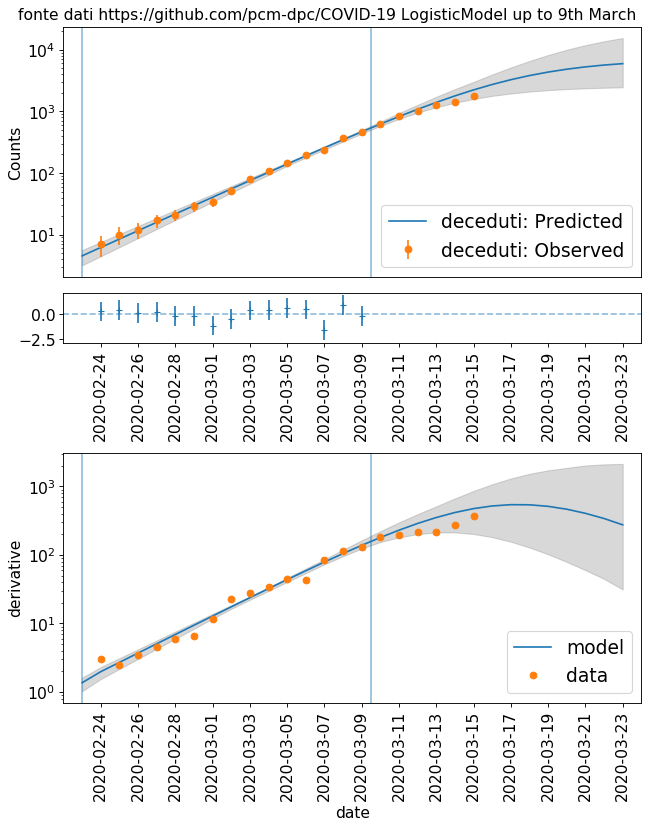

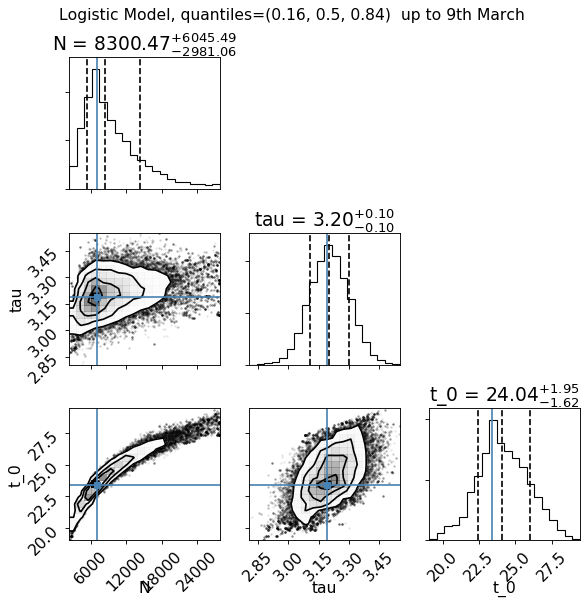

In [163]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
lm=LogisticModel()
bfm,mm,mcmc,data,fig=do_analysis(lm,data,t_start=0,t_stop=15.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s up to 9th March'%lm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Logistic Model, quantiles=%s  up to 9th March'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()
print(mm.show_report())

  1%|          | 6/500 [00:00<00:08, 56.13it/s]

 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
Exponential    N 5.554544e+01 1.906286e+02    -- 1.000000e+00  0.000000e+00            --  False
Exponential  tau 3.264490e+00 8.770694e-02    -- 3.000000e+00  0.000000e+00  1.000000e+03  False
Exponential  t_0 8.019082e+00 1.437488e+01    -- 1.000000e+01 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.45it/s]


mcmc run done, with 1 threads took 9.21 seconds


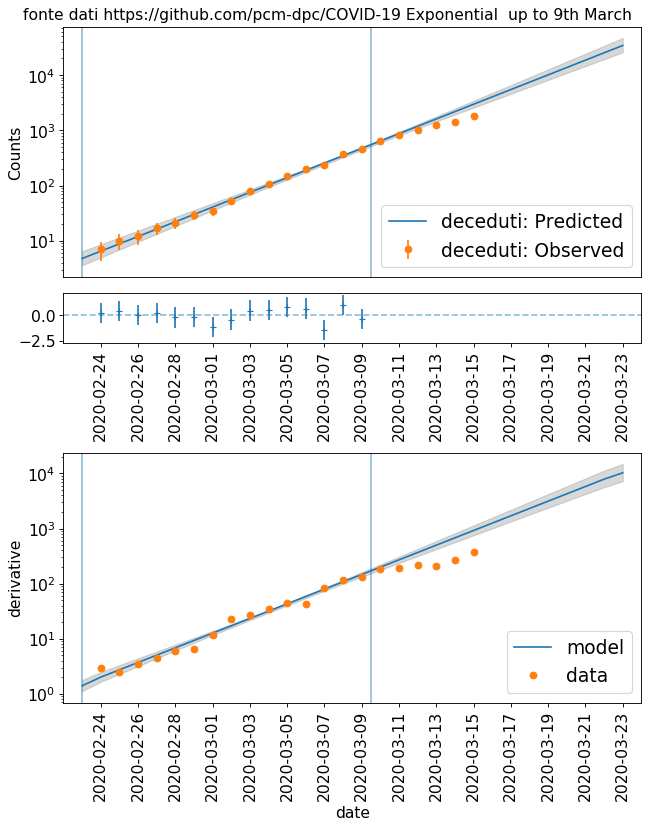

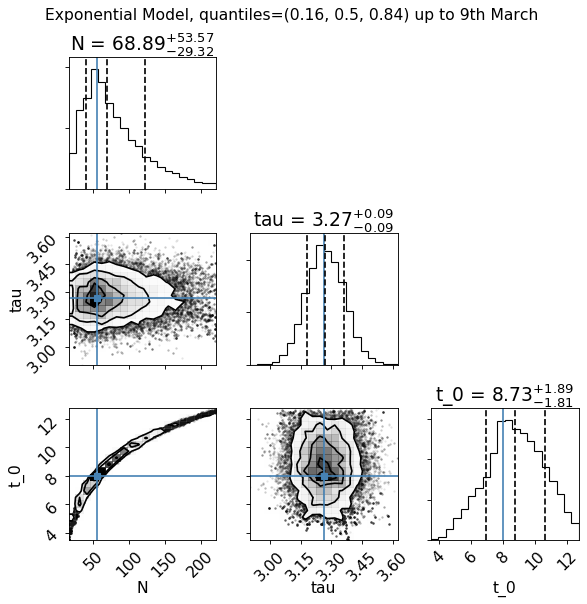

In [164]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
gm=ExpModel()
gm.parameters.t_0.val=10
gm.parameters.tau.val=3

bfm,mm,mcmc,data,fig=do_analysis(gm,data,t_start=0,t_stop=15.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s  up to 9th March'%gm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Exponential Model, quantiles=%s up to 9th March'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()
print(mm.show_report())

  1%|          | 6/500 [00:00<00:09, 52.20it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 3.225354e+03 2.687415e+02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 3.056289e+00 7.508961e-02    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
LogisticModel  t_0 2.039358e+01 4.564643e-01    -- 0.000000e+00 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 51.83it/s]


mcmc run done, with 1 threads took 9.68 seconds

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                3.225354e+03     0.000000e+00               -- False  False
LogisticModel  tau                3.056289e+00     0.000000e+00     1.000000e+01 False  False
LogisticModel  t_0                2.039358e+01    -3.000000e+01     1.000000e+02 False  False

converged=True
calls=249
------------------------------------------------------------------
| FCN = 12.52                   |     Ncalls=248 (248 total)     |
| EDM = 6.51E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit

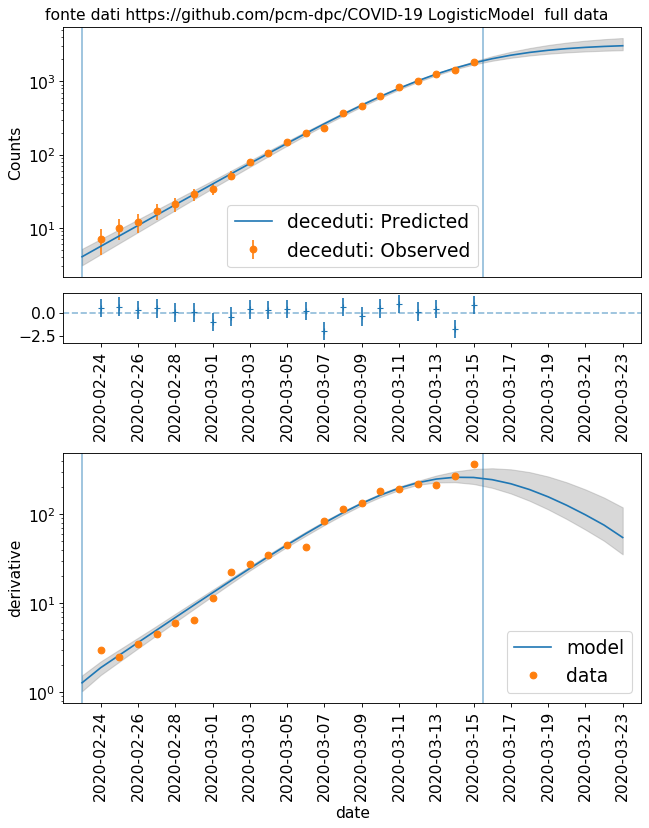

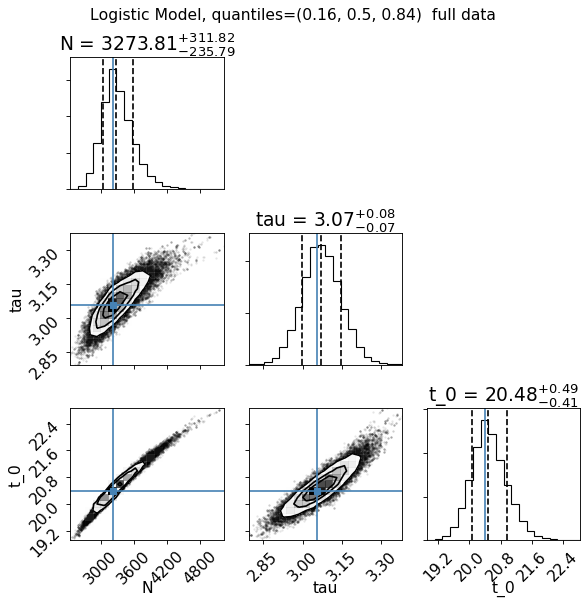

In [167]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
lm=LogisticModel()
bfm,mm,mcmc,data,fig=do_analysis(lm,data,t_start=0,t_stop=21.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s  full data'%lm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Logistic Model, quantiles=%s  full data'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()
print(mm.show_report())

  1%|          | 5/500 [00:00<00:11, 42.58it/s]

log10(R0)/tau 0.11388955636816649
doubling time 2.6431747147284765
 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
GrowthModel  eta 3.191243e-02 1.872005e-02    -- 1.000000e+00  0.000000e+00            --  False
GrowthModel   R0 1.199218e+00 1.419208e-01    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  tau 6.927608e-01 4.481684e-01    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  t_0 5.145541e+00 2.247876e+00    -- 0.000000e+00 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:10<00:00, 49.38it/s]


mcmc run done, with 1 threads took 10.15 seconds

**************************************************************************************************
Fit report

Model: None
 model name name par type units     val      phys. bound. min phys. bound. max  log  frozen
----------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
GrowthModel  eta                3.191243e-02     0.000000e+00               -- False  False
GrowthModel   R0                1.199218e+00     0.000000e+00     1.000000e+01 False  False
GrowthModel  tau                6.927608e-01     0.000000e+00     1.000000e+01 False  False
GrowthModel  t_0                5.145541e+00    -3.000000e+01     1.000000e+02 False  False

converged=True
calls=172
------------------------------------------------------------------
| FCN = 116.7                   |     Ncalls=171 (171 total)     |
| EDM = 1.21E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------

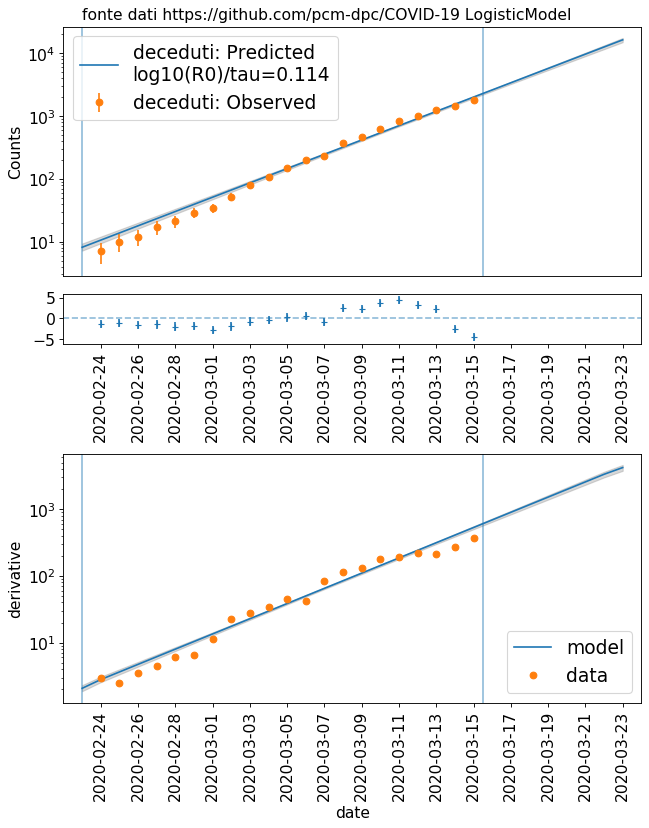

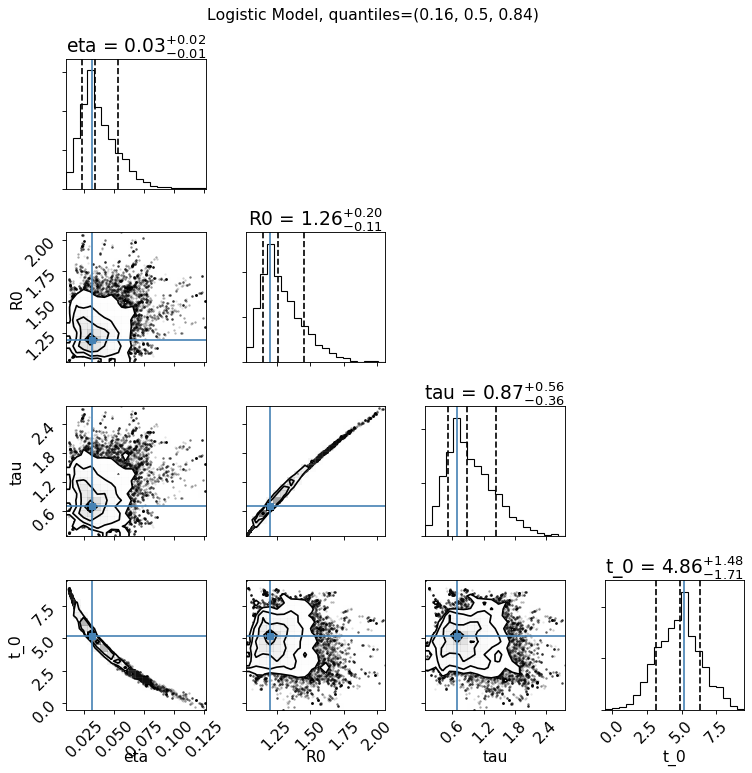

In [168]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
model=GrowthModel()
bfm,mm,mcmc,data,fig=do_analysis(model,data,t_start=0,t_stop=21.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s'%lm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Logistic Model, quantiles=%s'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()
print(mm.show_report())

In [139]:

def plot_ratio(name,plot_vline=False):
    data_i,df_i =get_data_protezione_civile(name,fake_error=False)
    df_i['data']=pd.to_datetime(df_i['data'])
    x=df_i['data']
    y_i=df_i[name].array
    y_n=0
    for region in ['Lombardia','Piemonte','Veneto','Emilia Romagna']:
        data_n,df_n =get_data_protezione_civile(name,fake_error=False,regione=region)
        y_n+=df_n[name].array
    
    if plot_vline is True:
        plt.axvline(df_i['data'][12],ls='--',c='r',label='north to south massive migration')
        plt.axvline(df_i['data'][14],ls='--',c='y',label='north lockdown')
    
    po_ratio=1.7
    y_i=np.array(y_i)
    y_n=np.array(y_n)
    y_r=np.array(y_i-y_n)
    #y=np.gradient(y,edge_order=2)
    #y=np.diff(y,)
    #x=np.array(x)
    #y=np.array(y_r/y_n)
    #plt.plot(np.array(x),y,'-o',label='%s (Italy-North)/North'%name)
    plt.plot(np.array(x),y_n ,'-o',label='%s North'%name)
    plt.plot(np.array(x),y_r*po_ratio ,'-o',label='%s (Italy-North)*1.7'%name)
    
    
    
    
    df_i['data'] =df_i['data'] + pd.DateOffset(days=-7)
    dx=df_i['data']
    #x=np.array(x)
    plt.plot(np.array(x),y_r*po_ratio ,'-o',label='%s (Italy-North)*1.7 shifted 7 days'%name)
    plt.semilogy()
    #name='deaths'
    plt.ylabel('normalized to 1')
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.title('%s,    North= Lombardia, Piemonte, Veneto , Emilia Romagna'%name )


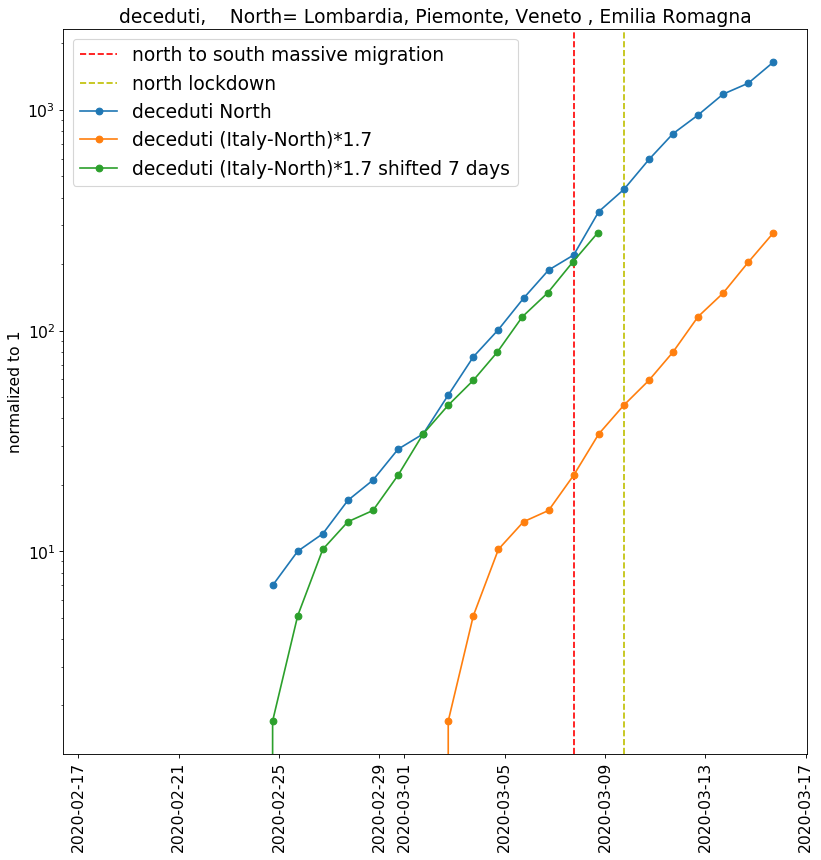

In [140]:
plot_ratio('deceduti',plot_vline=True)
#plot_ratio(name='ricoverati_con_sintomi',plot_vline=True)
#plot_ratio(name='totale_ospedalizzati')
#plot_ratio(name='totale_casi',plot_vline=True)


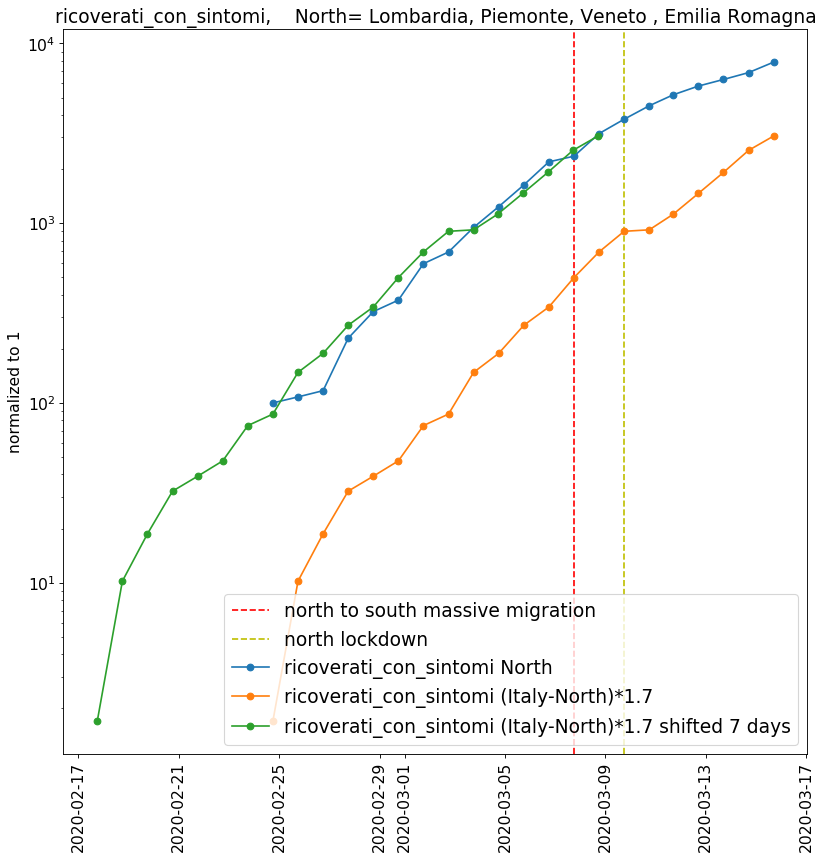

In [141]:
plot_ratio(name='ricoverati_con_sintomi',plot_vline=True)


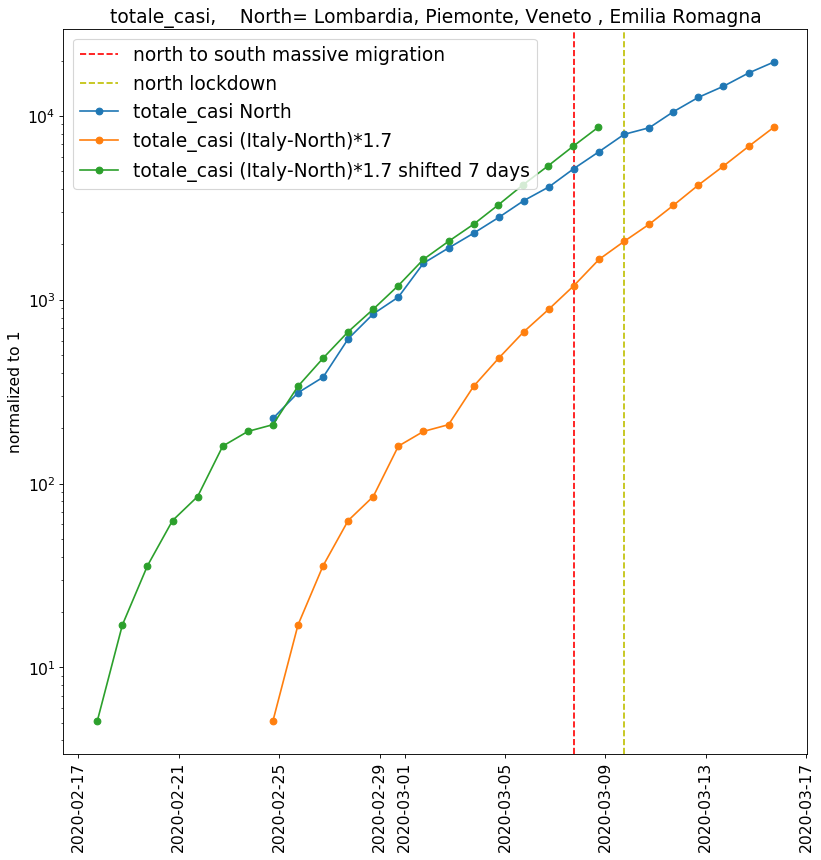

In [142]:
plot_ratio(name='totale_casi',plot_vline=True)


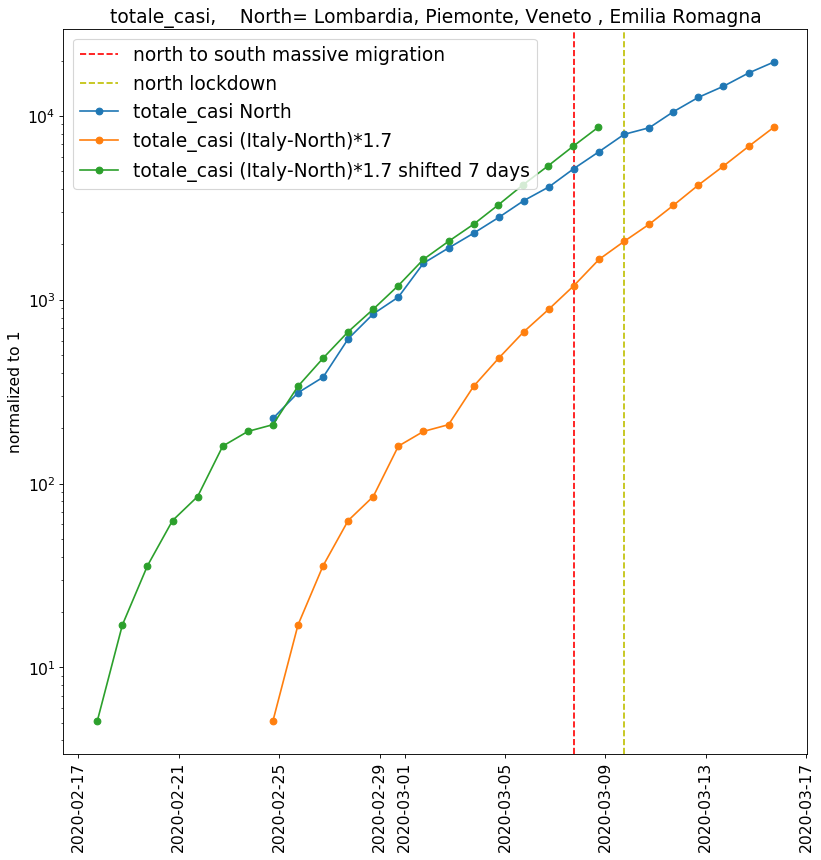

In [146]:
plot_ratio(name='totale_casi',plot_vline=True)


In [151]:
data_i,df_i =get_data_protezione_civile('totale_casi',fake_error=False)

[]

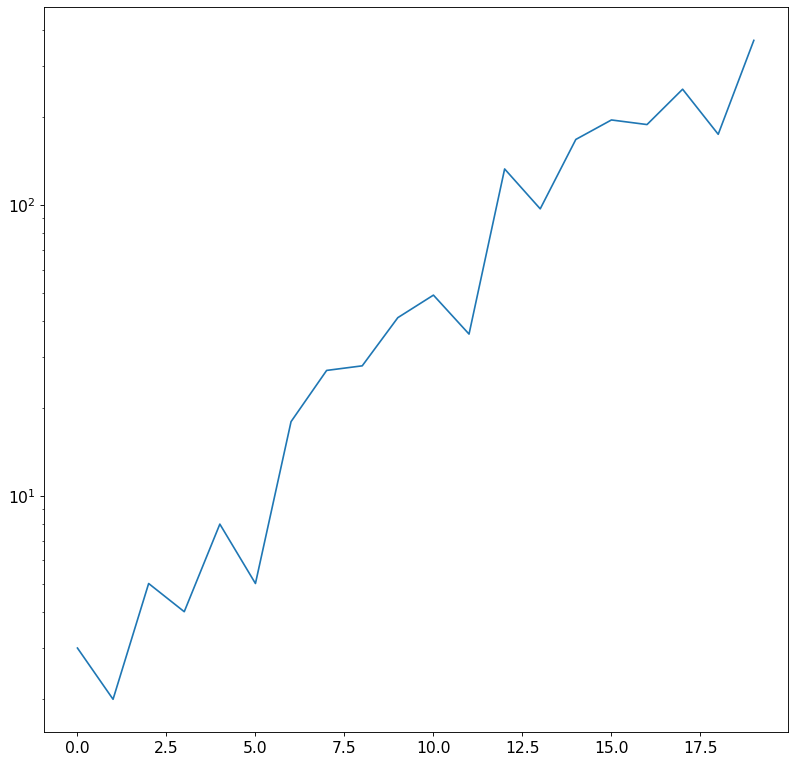

In [159]:
plt.plot(np.diff(df_i['deceduti']))
plt.semilogy()

In [153]:
df_i

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837
